In [11]:
import meshio
import fenics as f
import h_transport_materials as htm
import matplotlib.pyplot as plt
import numpy as np
import festim as F


def convert_med_to_xdmf(
    med_file,
    cell_file="mesh_domains.xdmf",
    facet_file="mesh_boundaries.xdmf",
    cell_type="tetra",
    facet_type="triangle",
):
    """Converts a MED mesh to XDMF
    Args:
        med_file (str): the name of the MED file
        cell_file (str, optional): the name of the file containing the
            volume markers. Defaults to "mesh_domains.xdmf".
        facet_file (str, optional): the name of the file containing the
            surface markers.. Defaults to "mesh_boundaries.xdmf".
        cell_type (str, optional): The topology of the cells. Defaults to "tetra".
        facet_type (str, optional): The topology of the facets. Defaults to "triangle".
    Returns:
        dict, dict: the correspondance dict, the cell types
    """
    msh = meshio.read(med_file)

    correspondance_dict = msh.cell_tags

    cell_data_types = msh.cell_data_dict["cell_tags"].keys()

    for mesh_block in msh.cells:
        if mesh_block.type == cell_type:

            meshio.write_points_cells(
                cell_file,
                msh.points,
                [mesh_block],
                cell_data={"f": [-1 * msh.cell_data_dict["cell_tags"][cell_type]]},
            )
        elif mesh_block.type == facet_type:
            meshio.write_points_cells(
                facet_file,
                msh.points,
                [mesh_block],
                cell_data={"f": [-1 * msh.cell_data_dict["cell_tags"][facet_type]]},
            )

    return correspondance_dict, cell_data_types

In [12]:
mesh_file = "../challenge_D/challenge_mesh.med"

correspondance_dict, cell_data_types = convert_med_to_xdmf(
    mesh_file,
    cell_type="triangle",
    facet_type="line",
    cell_file="../challenge_D/mesh_domains.xdmf",
    facet_file="../challenge_D/mesh_boundaries.xdmf",
)

print("This is the correspondance dict:")
print(correspondance_dict)

This is the correspondance dict:
{-6: ['solid'], -7: ['inner_boundary'], -8: ['outer_boundary']}


In [13]:
# IDs for volumes and surfaces (must be the same as in xdmf files)

id_solid = 6

id_inner_boundary = 7
id_outer_boundary = 8

my_model = F.Simulation(log_level=40)

# define mesh
my_model.mesh = F.MeshFromXDMF(
    volume_file="../challenge_D/mesh_domains.xdmf",
    boundary_file="../challenge_D/mesh_boundaries.xdmf",
)

# material properties
D_mat = htm.diffusivities.filter(material="gold")[0]

D_0 = D_mat.pre_exp.magnitude
E_D = D_mat.pre_exp.magnitude

my_mat = F.Material(id=id_solid, D_0=D_0, E_D=E_D, thermal_cond=315)
my_model.materials = F.Materials([my_mat])

# define temperature
my_model.T = F.HeatTransferProblem(transient=False)

# define boundary conditions
my_model.boundary_conditions = [
    F.ImplantationDirichlet(
        surfaces=id_inner_boundary,
        phi=1e19,
        R_p=3e-09,
        D_0=D_0,
        E_D=E_D,
    ),
    F.DirichletBC(surfaces=id_outer_boundary, value=0, field="solute"),
    F.DirichletBC(surfaces=id_inner_boundary, value=600, field="T"),
    F.ConvectiveFlux(h_coeff=1e4, T_ext=300, surfaces=id_outer_boundary),
]

# define exports

my_derived_quantities = F.DerivedQuantities(
    [
        F.SurfaceFlux(field="solute", surface=id_outer_boundary),
        F.TotalVolume(field="solute", volume=id_solid),
    ],
)
my_model.exports = F.Exports([my_derived_quantities])

my_model.dt = F.Stepsize(
    initial_value=1,
    stepsize_change_ratio=1.05,
    stepsize_stop_max=1 / 10,
    dt_min=1e-04,
    t_stop=1e09,
)

my_model.settings = F.Settings(
    transient=True,
    maximum_iterations=30,
    final_time=1.2e03,
    absolute_tolerance=1e-10,
    relative_tolerance=1e-10,
)

my_model.initialise()
my_model.run()

Succesfully load mesh with 17641 cells
Defining variational problem heat transfers


/home/jdark/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/stepsize.py:54: DeprecationWarning: stepsize_stop_max and t_stop attributes will be deprecated in a future release, please use max_stepsize instead
  warnings.warn(


Solving stationary heat equation
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/jdark/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(
/home/jdark/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        1.2e+03 s    Elapsed time so far: 36.0 s


Steady surface flux = 7.69e+11 H/m2/s
Steady inventory = 3.88e+14 H/m


Text(0.5, 1.0, 'Mobile tritium concentration (H/m3)')

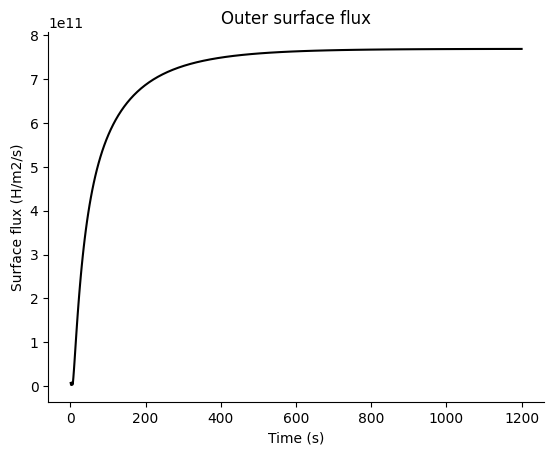

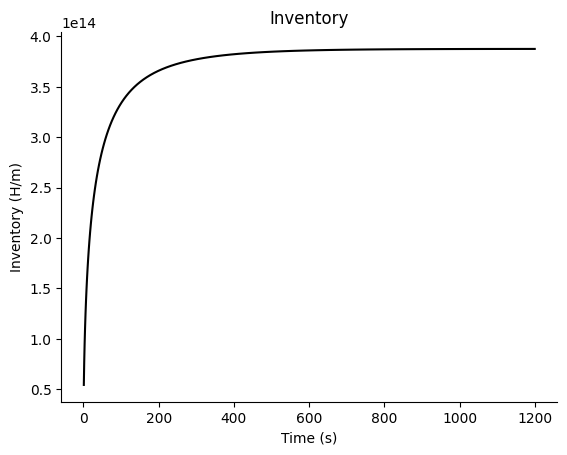

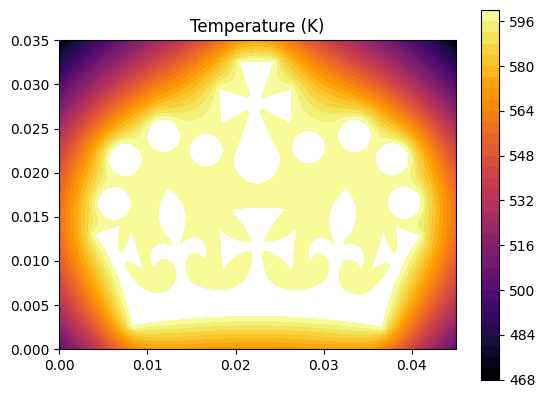

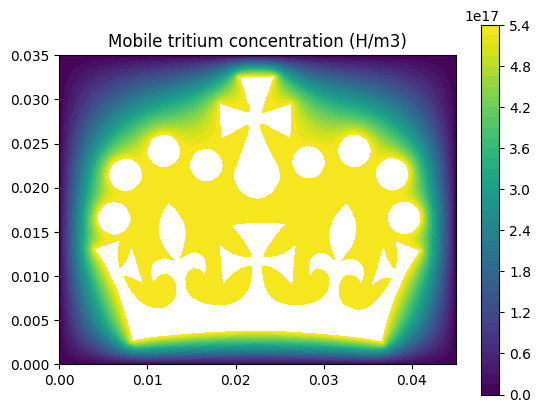

In [15]:
surface_flux = np.abs(my_derived_quantities[0].data)
inv = my_derived_quantities[1].data
t = my_derived_quantities.t

plt.figure()
plt.title("Outer surface flux")
plt.plot(t, surface_flux, color="black")
plt.xlabel(r"Time (s)")
plt.ylabel(r"Surface flux (H/m2/s)")
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout

print(f"Steady surface flux = {surface_flux[-1]:.2e} H/m2/s")

plt.figure()
plt.title("Inventory")
plt.plot(t, inv, color="black")
plt.xlabel(r"Time (s)")
plt.ylabel(r"Inventory (H/m)")
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout

print(f"Steady inventory = {inv[-1]:.2e} H/m")

plt.figure()
sol = my_model.T.T
CS = f.plot(sol, cmap="inferno")
plt.colorbar(CS)
plt.title(r"Temperature (K)")

plt.figure()
sol = my_model.h_transport_problem.mobile.mobile_concentration()
CS = f.plot(sol)
plt.colorbar(CS)
plt.title(r"Mobile tritium concentration (H/m3)")